# Prepear

In [71]:
# https://bamblebam.medium.com/audio-classification-and-regression-using-pytorch-48db77b3a5ec
# The above code will import all the necessary libraries and initialize your device to either CPU or GPU. 

import torchaudio as ta
from torch.utils.data import DataLoader
import numpy as numpy

import numpy as np
import pandas as pd

import tqdm

import torch
from torch import nn
import torchaudio

import cnn

if torch.cuda.is_available():
    print('yes')
    device='cuda'
else:
    device='cpu'

import torch
from cnn import CNNetwork
import torchaudio
import os


import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from glob import glob
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import pylab
import itertools

import nussl
from importlib import reload 
import nussl_fram
reload (nussl_fram)

from nussl_fram import dataset_v3
from sklearn.model_selection import train_test_split

import json # to print dictionary

import shutil
import logging

from concurrent.futures import ThreadPoolExecutor 

Device is cpu


In [38]:
# constance
# sr = 8000
# num_features = 129  # number of frequency bins in STFT

sr = 44100
num_features = 1025  # number of frequency bins in STFT

window_length = (num_features-1)*2
hope_length = window_length/4

## Model

In [39]:
# define the building blocks
num_sources = 3  # how many sources to estimate
mask_activation = 'sigmoid'  # activation function for masks
num_audio_channels = 1  # number of audio channels

modules = {
    'mix_magnitude': {},
    'my_log_spec': {
        'class': 'AmplitudeToDB'
    },
    'my_norm': {
        'class': 'BatchNorm',
    },
    'mask': {
        'class': 'Embedding',
        'args': {
            'num_features': num_features,
            'hidden_size': num_features,
            'embedding_size': num_sources,
            'activation': mask_activation,
            'num_audio_channels': num_audio_channels,
            'dim_to_embed': [2, 3]  # embed the frequency dimension (2) for all audio channels (3)
        }
    },
    'my_estimates': {
        'class': 'Mask',
    },
}
# define the topology
connections = [
    ['my_log_spec',    ['mix_magnitude',       ]],
    ['my_norm',        ['my_log_spec',         ]],
    ['mask',           ['my_norm',             ]],
    ['my_estimates',   ['mask', 'mix_magnitude']]
]


# define the outputs
output = ['my_estimates', 'mask']


In [40]:
# configuratia
config = {
    'name': 'simple_model',
    'modules': modules,
    'connections': connections,
    'output': output
}

print(json.dumps(config, indent=2))

{
  "name": "simple_model",
  "modules": {
    "mix_magnitude": {},
    "my_log_spec": {
      "class": "AmplitudeToDB"
    },
    "my_norm": {
      "class": "BatchNorm"
    },
    "mask": {
      "class": "Embedding",
      "args": {
        "num_features": 1025,
        "hidden_size": 1025,
        "embedding_size": 3,
        "activation": "sigmoid",
        "num_audio_channels": 1,
        "dim_to_embed": [
          2,
          3
        ]
      }
    },
    "my_estimates": {
      "class": "Mask"
    }
  },
  "connections": [
    [
      "my_log_spec",
      [
        "mix_magnitude"
      ]
    ],
    [
      "my_norm",
      [
        "my_log_spec"
      ]
    ],
    [
      "mask",
      [
        "my_norm"
      ]
    ],
    [
      "my_estimates",
      [
        "mask",
        "mix_magnitude"
      ]
    ]
  ],
  "output": [
    "my_estimates",
    "mask"
  ]
}


## Prep Data

In [41]:
nussl.utils.seed(0)  # make sure this does the same thing each time

stft_params = nussl.STFTParams(window_length=window_length, hop_length=hope_length)
tfm = nussl.datasets.transforms.Compose([
    nussl.datasets.transforms.PhaseSensitiveSpectrumApproximation(),
    nussl.datasets.transforms.MagnitudeWeights(),
    nussl.datasets.transforms.ToSeparationModel()
])

path = os.path.join(os.getcwd(), "audio")
# TODO - update to 44100
uds = dataset_v3(path, sample_rate=sr, stft_params=stft_params, transform=tfm)
print(f"There are {len(uds)} samples in the data")

There are 40 samples in the data


In [42]:
item = uds[0]
print(item.keys())
print(item['mix_magnitude'].shape)

dict_keys(['index', 'mix_magnitude', 'ideal_binary_mask', 'source_magnitudes', 'weights'])
torch.Size([432, 1025, 1])


In [43]:
for key in item:
    if torch.is_tensor(item[key]):
        item[key] = item[key].unsqueeze(0).float()

item['mix_magnitude'].shape

torch.Size([1, 432, 1025, 1])

# Demo - Use model

In [44]:
# model = nussl.ml.SeparationModel(config)
# print(model)

In [45]:
# output = model(item)
# i = 0
# plt.figure(figsize=(5, 5))
# plt.imshow(
#     output['my_estimates'][0, ..., 0, i].T.cpu().data.numpy(),
#     origin='lower')
# plt.title("Source")
# plt.show()

# plt.figure(figsize=(5, 5))
# plt.imshow(
#     output['mask'][0, ..., 0, i].T.cpu().data.numpy(),
#     origin='lower')
# plt.title("Mask")
# plt.show()

In [46]:
#Exmple train
# loss_dictionary = {
#     'L1Loss': {
#         'weight': 1.0,
#         'keys': {
#             'my_estimates': 'input',
#             'source_magnitudes': 'target',
#         }
#     }
# }

# optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [47]:
# Train on a single item (overfitting)
# train_closure = nussl.ml.train.closures.TrainClosure(
#     loss_dictionary, optimizer, model
# )

# loss_history = []
# n_iter = 100

# for i in range(n_iter):
#     loss_output = train_closure(None, item)
#     loss_history.append(loss_output['loss'])

# plt.plot(loss_history)
# plt.title('Train loss')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.show()

In [48]:
# Mask Visualizetion
# output = model(item)

# for i in range(output['my_estimates'].shape[-1]):
#     plt.figure(figsize=(10, 5))
#     plt.subplot(121)
#     plt.imshow(
#         output['my_estimates'][0, ..., 0, i].T.cpu().data.numpy(),
#         origin='lower')
#     plt.title("Source")

#     plt.subplot(122)
#     plt.imshow(
#         output['my_mask'][0, ..., 0, i].T.cpu().data.numpy(),
#         origin='lower')
#     plt.title("Mask")
#     plt.show()

# Train

In [49]:
BATCH_SIZE = 5
LEARNING_RATE = 1e-3

OUTPUT_FOLDER = os.path.join(os.getcwd(), 'output')
RESULTS_DIR = os.path.join(OUTPUT_FOLDER, 'results')

NUM_WORKERS = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

shutil.rmtree(os.path.join(RESULTS_DIR), ignore_errors=True)

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# adjust logging so we see output of the handlers
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Put together data
dataloader = torch.utils.data.DataLoader(
    uds, batch_size=BATCH_SIZE
)

# Build our model
model = nussl.ml.SeparationModel(config).to(DEVICE)
print(model)

# # Closures
# Build an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Set up loss functions and closure
# We'll use permutation invariant loss since we don't
# care what order the sine waves get output in, just that
# they are different.
loss_dictionary = {
    'L1Loss': {
        'weight': 1.0,  # In case of multiLoss: sum wigth == 1
        'keys': {
            'my_estimates': 'input',
            'source_magnitudes': 'target',
        }
    }
}

train_closure = nussl.ml.train.closures.TrainClosure(
    loss_dictionary, optimizer, model
)
val_closure = nussl.ml.train.closures.ValidationClosure(
    loss_dictionary, model
)

# Build the engine and add handlers
train_engine, val_engine = nussl.ml.train.create_train_and_validation_engines(
    train_closure, val_closure, device=DEVICE
)
nussl.ml.train.add_validate_and_checkpoint(
    OUTPUT_FOLDER, model, optimizer, uds, train_engine,
    val_data=dataloader, validator=val_engine
)
nussl.ml.train.add_stdout_handler(train_engine, val_engine)

SeparationModel(
  (layers): ModuleDict(
    (my_log_spec): AmplitudeToDB()
    (my_norm): BatchNorm(
      (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mask): Embedding(
      (linear): Linear(in_features=1025, out_features=3075, bias=True)
    )
    (my_estimates): Mask()
  )
)
Number of parameters: 3154952


In [50]:
train_engine.run(dataloader, max_epochs=5)

INFO:ignite.engine.engine.Engine:Engine run starting with max_epochs=5.
INFO:ignite.engine.engine.Engine:Engine run starting with max_epochs=1.
INFO:ignite.engine.engine.Engine:Epoch[1] Complete. Time taken: 00:00:09.245
INFO:ignite.engine.engine.Engine:Engine run complete. Time taken: 00:00:09.247
INFO:root:

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0005 
- Training loss:   0.000440 
- Validation loss: 0.000352 
- Epoch took: 0:00:21.571422 
- Time since start: 0:00:21.571464 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to c:\Users\shushu\Desktop\Sorona_Wave\output\checkpoints\best.model.pth. 
Output @ c:\Users\shushu\Desktop\Sorona_Wave\output 

INFO:ignite.engine.engine.Engine:Epoch[1] Complete. Time taken: 00:00:21.572
INFO:ignite.engine.engine.Engine:Engine run starting with max_epochs=1.
INFO:ignite.engine.engine.Engine:Epoch[1] Complete. Time taken: 00:00:09.239
INFO:ignite.engine.engine.Engine:Engine run complete. Time taken: 00:00:09.241
INFO:root:

EPO

State:
	iteration: 40
	epoch: 5
	epoch_length: 8
	max_epochs: 5
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	model_output: <class 'dict'>
	saved_model_path: c:\Users\shushu\Desktop\Sorona_Wave\output\checkpoints\best.model.pth
	output_folder: c:\Users\shushu\Desktop\Sorona_Wave\output

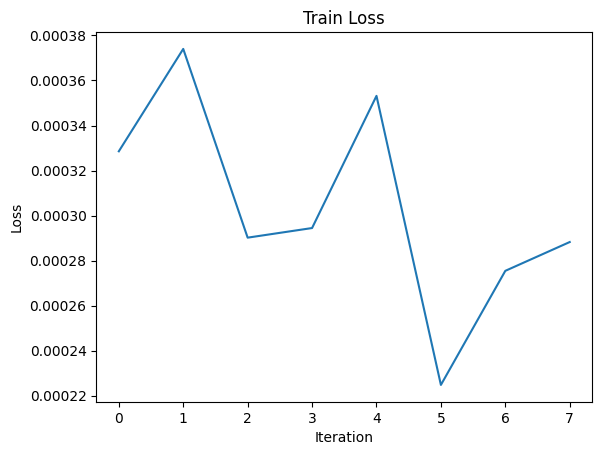

In [51]:
plt.plot(train_engine.state.iter_history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

In [52]:
saved_model = torch.load(train_engine.state.saved_model_path)
print(saved_model.keys())

dict_keys(['state_dict', 'config', 'metadata'])


In [53]:
print(saved_model['metadata'].keys())
print(saved_model['state_dict'].keys())

for key in saved_model['metadata']:
    print(f"{key}: {saved_model['metadata'][key]}")

for key in saved_model['state_dict']:
    print(f"{key}: {saved_model['state_dict'][key]}")

dict_keys(['config', 'nussl_version', 'optimizer', 'loss_dictionary', 'stft_params', 'sample_rate', 'num_channels', 'train_dataset', 'trainer.state_dict', 'trainer.state.epoch_history'])
odict_keys(['layers.my_norm.batch_norm.weight', 'layers.my_norm.batch_norm.bias', 'layers.my_norm.batch_norm.running_mean', 'layers.my_norm.batch_norm.running_var', 'layers.my_norm.batch_norm.num_batches_tracked', 'layers.mask.linear.weight', 'layers.mask.linear.bias'])
config: {'name': 'simple_model', 'modules': {'mix_magnitude': {}, 'my_log_spec': {'class': 'AmplitudeToDB', 'module_snapshot': 'class AmplitudeToDB(nn.Module):\n    """\n    Takes a magnitude spectrogram and converts it to a log\n    amplitude spectrogram in decibels.\n    \n    Args:\n        data (torch.Tensor): Magnitude spectrogram to convert to\n        log spectrogram.\n        ref (float): reference value. Defaults to 1.0.\n        amin (float): lowest possible value for numerical stability.\n        Defaults to 1e-8.\n    \n    

In [67]:
def visualize_and_embed(sources, y_axis='mel'):
    plt.figure(figsize=(10, 4))
    plt.subplot(111)
    nussl.utils.visualize_sources_as_masks(
        sources, db_cutoff=-60, y_axis=y_axis)
    plt.tight_layout()
    plt.show()

    nussl.play_utils.multitrack(sources, ext='.wav')

In [69]:
MODEL_PATH = os.path.join(OUTPUT_FOLDER, 'checkpoints/best.model.pth')
tt_dataset = dataset_v3(path, sample_rate = sr)
print(f"There are {len(uds)} samples in the data")

There are 40 samples in the data


## Demo - Evaluation

In [65]:
# item = tt_dataset[1]  # <-- This is an AugioSignal obj

# separator = nussl.separation.deep.DeepMaskEstimation(
#     item['mix'], model_path=MODEL_PATH
# )
# estimates = separator()

# visualize_and_embed(estimates)

In [66]:
# print(estimates)
# for signal in estimates:
#     print(signal)
#     signal.embed_audio()

## Evaluation

In [73]:

# make a separator with an empty audio signal initially
# this one will live on device (if one exists) and be used in a
# threadpool for speed
dme = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path = MODEL_PATH, device = device
)


def forward_on_device(audio_signal):
    # set the audio signal of the object to this item's mix
    dme.audio_signal = audio_signal
    masks = dme.forward()
    return masks


def separate_and_evaluate(item, masks, i):
    separator = nussl.separation.deep.DeepMaskEstimation(item['mix'])
    estimates = separator(masks)

    evaluator = nussl.evaluation.BSSEvalScale(
        list(item['sources'].values()), estimates,
        compute_permutation=True,
        source_labels = item['metadata']['lables']
    )
    scores = evaluator.evaluate()
    output_path = os.path.join(
        RESULTS_DIR, f"{i}.json"
    )
    with open(output_path, 'w') as f:
        json.dump(scores, f)

pool = ThreadPoolExecutor(max_workers=NUM_WORKERS)
for i, item in enumerate(tqdm.tqdm(tt_dataset)):
    masks = forward_on_device(item['mix'])
    if i == 0:
        separate_and_evaluate(item, masks, i)
    else:
        pool.submit(separate_and_evaluate, item, masks, i)
pool.shutdown(wait=True)

json_files = glob(f"{RESULTS_DIR}/*.json")
df = nussl.evaluation.aggregate_score_files(json_files)
report_card = nussl.evaluation.report_card(
    df, notes="Testing on sine waves", report_each_source=True)
print(report_card)



100%|██████████| 40/40 [00:05<00:00,  6.81it/s]


                                                                                          
                                 MEAN +/- STD OF METRICS                                  
                                                                                          
┌────────────┬──────────────────┬──────────────────┬──────────────────┬──────────────────┐
│ METRIC     │     OVERALL      │       FROG       │       HEN        │       PIG        │
╞════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╡
│ #          │       120        │        40        │        40        │        40        │
├────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SDR     │  -2.85 +/-  8.90 │  -1.75 +/-  9.00 │  -7.89 +/-  8.45 │   1.07 +/-  6.77 │
├────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SIR     │  10.16 +/- 11.93 │  12.56 +/- 12.76 │   8.68 +/- 13.98 │   9.24 +/-  8.20 │

C:\Users\shushu\AppData\Roaming\Python\Python310\site-packages\nussl\evaluation\report_card.py:83: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  for m in np.array(df.mean()).T
C:\Users\shushu\AppData\Roaming\Python\Python310\site-packages\nussl\evaluation\report_card.py:87: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  for s in np.array(df.std()).T
C:\Users\shushu\AppData\Roaming\Python\Python310\site-packages\nussl\evaluation\report_card.py:107: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In

In [74]:
df

,source,file,SI-SDR,SI-SIR,SI-SAR,SD-SDR,SNR,SRR,SI-SDRi,SD-SDRi,SNRi,MIX-SI-SDR,MIX-SD-SDR,MIX-SNR
0,frog,0.json,7.757199,23.750157,7.867863,7.699104,8.102250,26.464677,18.441187,18.383117,18.856959,-10.683988,-10.684013,-10.754709
1,frog,1.json,11.049514,27.410977,11.151071,11.026510,11.202114,33.797646,16.142078,16.119075,16.305364,-5.092564,-5.092566,-5.103250
2,frog,10.json,4.497168,24.877832,4.537136,2.844720,5.800999,7.841353,3.895320,2.243100,5.141155,0.601848,0.601620,0.659844
3,frog,11.json,5.160573,29.473846,5.176690,3.740727,6.304129,9.286751,2.420802,1.000960,3.558117,2.739771,2.739767,2.746013
4,frog,12.json,5.009389,29.426386,5.025123,3.506910,6.185021,8.846278,2.619117,1.116762,3.830232,2.390272,2.390148,2.354789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,pig,5.json,6.304556,12.644732,7.452439,5.763673,7.173563,15.078104,0.933203,0.392353,1.789297,5.371353,5.371320,5.384266
116,pig,6.json,4.608593,12.815982,5.320023,3.853796,5.835612,11.825276,0.503476,-0.251088,1.770503,4.105118,4.104884,4.065109
117,pig,7.json,7.120016,16.964263,7.595248,6.566459,7.873819,15.786504,4.427402,3.873853,5.172485,2.692614,2.692606,2.701334
118,pig,8.json,9.219744,11.794817,12.713794,9.042571,9.635060,23.024749,4.438646,4.261493,4.864440,4.781098,4.781078,4.770620
